In this notebook, I explore models for estimating survival using capture-recapture data in PyMC. These models include the Cormack-Jolly-Seber (CJS) and Jolly-Seber-Shwarz-Arnason (JSSA) frameworks. The primary difference between the two is that the JSSA model also tries to estimate the probability of entry into the population, which permits esimation of the superpopulation size.

In this notebook, I have drawn considerable inspiration from Austin Rochford's [notebook](https://austinrochford.com/posts/2018-01-31-capture-recapture.html) on capture-recapture in PyMC, the [second chapter](https://github.com/philpatton/autocapture) of my dissertation (a work in progress), and @mccrea2014.  

# Cormack-Jolly-Seber 

First, I explore fitting the Cormack-Jolly-Seber (CJS) model in PyMC. The CJS framework does not model entrance into the population, just survival, simplifying the model structure. There are many methods for estimating parameters in the model, including state-space formulations that explicitly model the latent alive/dead state $z.$ Following the theme of the previous notebooks, I instead marginalize this variable out of the model by using the so-called $M$-array. This is an array that contains the sufficient statistics for the CJS and JSSA models. For example, $m_{1,2}$ is the number of individuals that were released on at $t=1$ and were *first* recaptured on $t=2.$

|      | Number Released |           | Number recaptured |           | Never recaptured |
|------|:---------------:|----------:|:-----------------:|-----------|:----------------:|
|      |                 |    1982   |        1983       |    1984   |                  |
| 1981 |      $R_1$      | $m_{1,2}$ |     $m_{1,3}$     | $m_{1,4}$ | $R_1-m_{1\cdot}$ |
| 1982 |      $R_2$      |           |     $m_{2,3}$     | $m_{2,3}$ | $R_2-m_{2\cdot}$ |
| 1983 |      $R_3$      |           |                   | $m_{3,4}$ | $R_3-m_{3\cdot}$ |
: M-array 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm 
import pytensor.tensor as pt

from pymc.distributions.dist_math import factln
from scipy.linalg import circulant

plt.style.use('seaborn-v0_8-pastel')

def create_recapture_array(history):
    """Create the recapture array from a capture history."""
    _, occasion_count = history.shape
    interval_count = occasion_count - 1

    recapture_array = np.zeros((interval_count, interval_count), int)
    for occasion in range(occasion_count - 1):

        # which individuals, captured at t, were later recaptured?
        captured_this_time = history[:, occasion] == 1
        captured_later = (history[:, (occasion + 1):] > 0).any(axis=1)
        now_and_later = captured_this_time & captured_later
        
        # when were they next recaptured? 
        remaining_history = history[now_and_later, (occasion + 1):]
        next_capture_occasion = (remaining_history.argmax(axis=1)) + occasion 

        # how many of them were there?
        ind, count = np.unique(next_capture_occasion, return_counts=True)
        recapture_array[occasion, ind] = count
        
    return recapture_array.astype(int)

def create_m_array(history):
    '''Create the m-array from a capture history.'''

    # leftmost column of the m-array
    number_released = history.sum(axis=0)

    # core of the m-array 
    recapture_array = create_recapture_array(history)
    number_recaptured = recapture_array.sum(axis=1)

    # no animals that were released on the last occasion are recaptured
    number_recaptured = np.append(number_recaptured, 0)
    never_recaptured = number_released - number_recaptured

    # add a dummy row at the end to make everything stack 
    zeros = np.zeros(recapture_array.shape[1])
    recapture_array = np.row_stack((recapture_array, zeros))

    # stack the relevant values into the m-array 
    m_array = np.column_stack((number_released, recapture_array, never_recaptured))

    return m_array.astype(int)

def fill_lower_diag_ones(x):
    '''Fill the lower diagonal of a matrix with ones.'''
    return pt.triu(x) + pt.tril(pt.ones_like(x), k=-1)

As an example, I use the cormorant data from @mccrea2014, Table 4.6. These data come from an eleven year capture-recapture study between 1982 and 1993. These were breeding cormorants of unknown age. The data is summarized in the $M$-array below. The last column is the number that were never recapured. The number released can be calculated from the array.

In [2]:
cormorant = np.loadtxt('cormorant.csv', delimiter=',').astype(int)
cormorant

array([[ 10,   4,   2,   2,   0,   0,   0,   0,   0,   0,  12],
       [  0,  42,  12,  16,   1,   0,   1,   1,   1,   0,  83],
       [  0,   0,  85,  22,   5,   5,   2,   1,   0,   1,  53],
       [  0,   0,   0, 139,  39,  10,  10,   4,   2,   0,  94],
       [  0,   0,   0,   0, 175,  60,  22,   8,   4,   2, 199],
       [  0,   0,   0,   0,   0, 159,  46,  16,   5,   2, 193],
       [  0,   0,   0,   0,   0,   0, 191,  39,   4,   8, 171],
       [  0,   0,   0,   0,   0,   0,   0, 188,  19,  23, 284],
       [  0,   0,   0,   0,   0,   0,   0,   0, 101,  55, 274],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  84,  97]])

In [3]:
interval_count, T = cormorant.shape

number_recaptured = cormorant[:,:-1]
never_recaputured = cormorant[:,-1]
number_released = number_recaptured.sum(axis=1) + never_recaputured

This PyMC model will look different than the ones in previous notebooks, simply because it requires many tricks to get the probabilities in the correct format for the $m$-array, then modeling the $m$-array as a multinomial with the associated cell probabilities. These probabilities correspond to the situations in the $m$-array, such as the probability that an animal survived and was not recaptured until a later date. In this example, I model survival as time-varying, i.e., $\phi(t).$

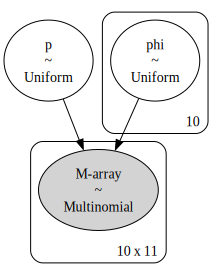

In [4]:
# utility vectors for creating arrays and array indices
intervals = np.arange(interval_count)
row_indices = np.reshape(intervals, (interval_count, 1))
col_indices = np.reshape(intervals, (1, interval_count))

# matrix indicating the number of intervals between sampling occassions
intervals_between = np.clip(col_indices - row_indices, 0, np.inf)

with pm.Model() as phit:

    # priors for catchability and survival 
    p = pm.Uniform('p', 0, 1)
    phi = pm.Uniform('phi', 0, 1, shape=interval_count)

    # broadcast phi into a matrix 
    phi_mat = pt.ones_like(number_recaptured) * phi
    phi_mat = fill_lower_diag_ones(phi_mat) # fill irrelevant values 
    
    # probability of surviving between i and j in the m-array 
    p_alive = pt.cumprod(phi_mat, axis=1)
    p_alive = pt.triu(p_alive) # select relevant (upper triangle) values

    # probability of not being captured between i and j
    p_not_cap = pt.triu((1 - p) ** intervals_between)

    # probabilities associated with each cell in the m-array
    nu = p_alive * p_not_cap * p

    # probability for the animals that were never recaptured
    chi = 1 - nu.sum(axis=1)

    # combine the probabilities into a matrix
    chi = pt.reshape(chi, (interval_count, 1))
    marr_probs = pt.horizontal_stack(nu, chi)

    # distribution of the m-array 
    marr = pm.Multinomial(
        'M-array',
        n=number_released,
        p=marr_probs,
        observed=cormorant
    )

pm.model_to_graphviz(phit)

In [5]:
with phit:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, phi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


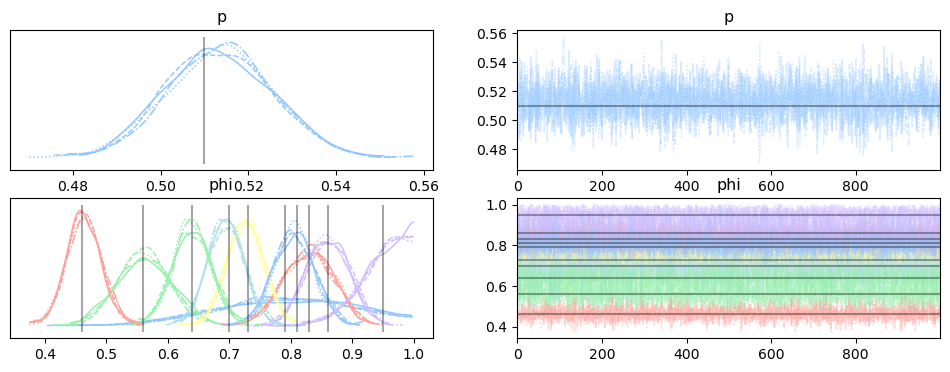

In [6]:
mccrea_p = [0.51]
mccrea_phi = [0.79, 0.56, 0.83, 0.86, 0.73, 0.70, 0.81, 0.64, 0.46, 0.95]

az.plot_trace(
    idata, 
    lines=[("phi", {}, [mccrea_phi]), ("p", {}, [mccrea_p])] 
);

The model samples fairly quickly in this parameterization. The traceplots above include comparisons to the estimates from @mccrea2014. While a bit messy, the plots show a high level of agreement between their estimates and the ones here. To clean things up a bit, I plot the estimates for $\phi$ over time, along with the 94\% credible intervals

In [7]:
import seaborn as sns
pal = sns.color_palette('pastel')

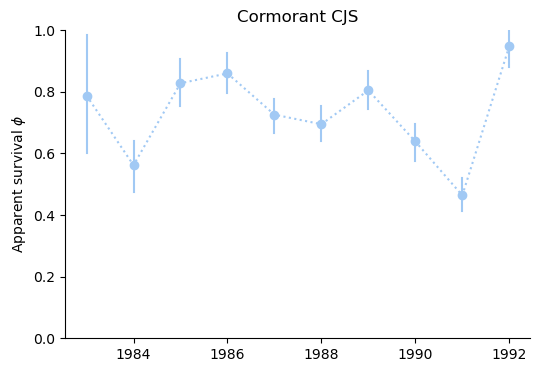

In [8]:
#| fig-cap: Posterior mean and 94% credible intervals of apparent surival from the cormorant CJS.
#| fig-lab: post

summary = az.summary(idata).iloc[1:,:]

phi_mean = summary.iloc[:,0]
phi_low = summary.iloc[:,2]
phi_high = summary.iloc[:,3]

t = np.arange(1983, 1993)

fig, ax = plt.subplots(figsize=(6,4))

col = pal[0]
ax.scatter(t, phi_mean, label='Estimate', color=col)
ax.plot(t, phi_mean, linestyle='dotted', color=col)
ax.plot([t, t], [phi_low, phi_high], label='94% Interval', color=col)

ax.set_ylabel(r'Apparent survival $\phi$', rotation=90)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylim((0,1))

ax.set_title(r'Cormorant CJS')

plt.show()

# Jolly-Seber-Shwarz-Arnason (JSSA)

The second modeling framework I explore is the Jolly-Seber-Shwarz-Arnason (JSSA) model. This attempts to model entrants into the population, further permitting the estimation of the superpopulation size. As a demonstration, I use the classic European dipper data of @lebreton1992. I first convert the dataset into the $M$-array, since the data is in capture history format.

In [9]:
dipper = np.loadtxt('dipper.csv', delimiter=',').astype(int)
dipper[:5]

array([[1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 0, 0]])

In [10]:
dipper_m = create_m_array(dipper)
dipper_m

array([[22, 11,  2,  0,  0,  0,  0,  9],
       [60,  0, 24,  1,  0,  0,  0, 35],
       [78,  0,  0, 34,  2,  0,  0, 42],
       [80,  0,  0,  0, 45,  1,  2, 32],
       [88,  0,  0,  0,  0, 51,  0, 37],
       [98,  0,  0,  0,  0,  0, 52, 46],
       [93,  0,  0,  0,  0,  0,  0, 93]])

The JSSA model requires modeling the number of unmarked animals that were released during an occasion. We can calculate this using the $m$-array by subtracting the number of marked animals who were released from the total number of released animals. 

In [11]:
recapture_array = create_recapture_array(dipper)

number_released = dipper_m[:,0]
number_marked_released = recapture_array.sum(axis=0)

# shift number_released to get the years to align   
number_unmarked_released = number_released[1:] - number_marked_released

# add the number released on the first occasion 
number_unmarked_released = np.concatenate(
    ([number_released[0]], number_unmarked_released)
)

number_unmarked_released

array([22, 49, 52, 45, 41, 46, 39])

Similar to the CJS model, this model requires a number of tricks to vectorize the operations. Many pertain to the distribution of the unmarked individuals. Similar to [occupancy notebook](https://philpatton.github.io/occ.html), I use a custom distribution to model the entrants into the population. Austin Rochford refers to this as an incomplete multinomial distribution. 

In [12]:
n, occasion_count = dipper.shape
interval_count = occasion_count - 1

# generate indices for the m_array  
intervals = np.arange(interval_count)
row_indices = np.reshape(intervals, (interval_count, 1))
col_indices = np.reshape(intervals, (1, interval_count))

# matrix indicating the number of intervals between sampling occassions
intervals_between = np.clip(col_indices - row_indices, 0, np.inf)

# index for generating sequences like [[0], [0,1], [0,1,2]]
alive_yet_unmarked_index = circulant(np.arange(occasion_count))

In [13]:
def logp(x, n, p):
    
    x_last = n - x.sum()
    
    # calculate thwe logp for the observations
    res = factln(n) + pt.sum(x * pt.log(p) - factln(x)) \
            + x_last * pt.log(1 - p.sum()) - factln(x_last)
    
    # ensure that the good conditions are met.
    good_conditions = pt.all(x >= 0) & pt.all(x <= n) & (pt.sum(x) <= n) & \
                        (n >= 0)
    res = pm.math.switch(good_conditions, res, -np.inf)

    return res

In [14]:
# m-array for the CJS portion of the likelihood
cjs_marr = dipper_m[:-1,1:]
cjs_marr

array([[11,  2,  0,  0,  0,  0,  9],
       [ 0, 24,  1,  0,  0,  0, 35],
       [ 0,  0, 34,  2,  0,  0, 42],
       [ 0,  0,  0, 45,  1,  2, 32],
       [ 0,  0,  0,  0, 51,  0, 37],
       [ 0,  0,  0,  0,  0, 52, 46]])

Aside from the unmarked portion of the model, the JSSA model is essentially identical to the CJS model above. In this version, I also model survival as time-varying, holding other parameters constant $p(\cdot)\phi(t)b_0(\cdot)$

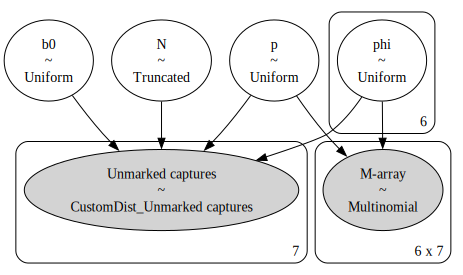

In [15]:
# JSSA produces this warning. it's unclear why since it samples well
import warnings
warnings.filterwarnings(
    "ignore", 
    message="Failed to infer_shape from Op AdvancedSubtensor"
)

with pm.Model() as jssa:

    ## Priors
    
    # catchability, survival, and pent
    p = pm.Uniform('p', 0., 1.)
    phi = pm.Uniform('phi', 0., 1., shape=interval_count)
    b0 = pm.Uniform('b0', 0., 1.)
    # beta = pm.Dirichlet('beta', np.ones(interval_count))
    
    # # only estimate first beta, others constant
    b_other = (1 - b0) / (interval_count)
    beta = pt.concatenate(
        ([b0], pt.repeat(b_other, interval_count))
    )

    # improper flat prior for N
    flat_dist = pm.Flat.dist()
    total_captured = number_unmarked_released.sum()
    N = pm.Truncated("N", flat_dist, lower=total_captured)

    ## Entry 
    
    # add [1] to ensure the addition of the raw beta_0
    p_alive_yet_unmarked = pt.concatenate(
        ([1], pt.cumprod((1 - p) * phi))
    )

    # tril produces the [[0], [0,1], [0,1,2]] patterns for the recursion
    psi = pt.tril(
        beta * p_alive_yet_unmarked[alive_yet_unmarked_index]
    ).sum(axis=1)

    # distribution for the unmarked animals
    unmarked = pm.CustomDist(
        'Unmarked captures', 
        N, 
        psi * p, 
        logp=logp, 
        observed=number_unmarked_released
    )

    ## CJS
    
    # broadcast phi into a matrix 
    phi_mat = pt.ones_like(recapture_array) * phi
    phi_mat = fill_lower_diag_ones(phi_mat) # fill irrelevant values 
    
    # probability of surviving between i and j in the m-array 
    p_alive = pt.cumprod(phi_mat, axis=1)
    p_alive = pt.triu(p_alive) # select relevant (upper triangle) values
    
    # p_not_cap: probability of not being captured between i and j
    p_not_cap = pt.triu((1 - p) ** intervals_between)

    # nu: probabilities associated with each cell in the m-array
    nu = p_alive * p_not_cap * p

    # probability for the animals that were never recaptured
    chi = 1 - nu.sum(axis=1)

    # combine the probabilities into a matrix
    chi = pt.reshape(chi, (interval_count, 1))
    marr_probs = pt.horizontal_stack(nu, chi)

    # distribution of the m-array 
    marr = pm.Multinomial(
        'M-array',
        n=number_released[:-1], # last count irrelevant for CJS
        p=marr_probs,
        observed=cjs_marr
    )

pm.model_to_graphviz(jssa)

In [16]:
with jssa:
    dat = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, phi, b0, N]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


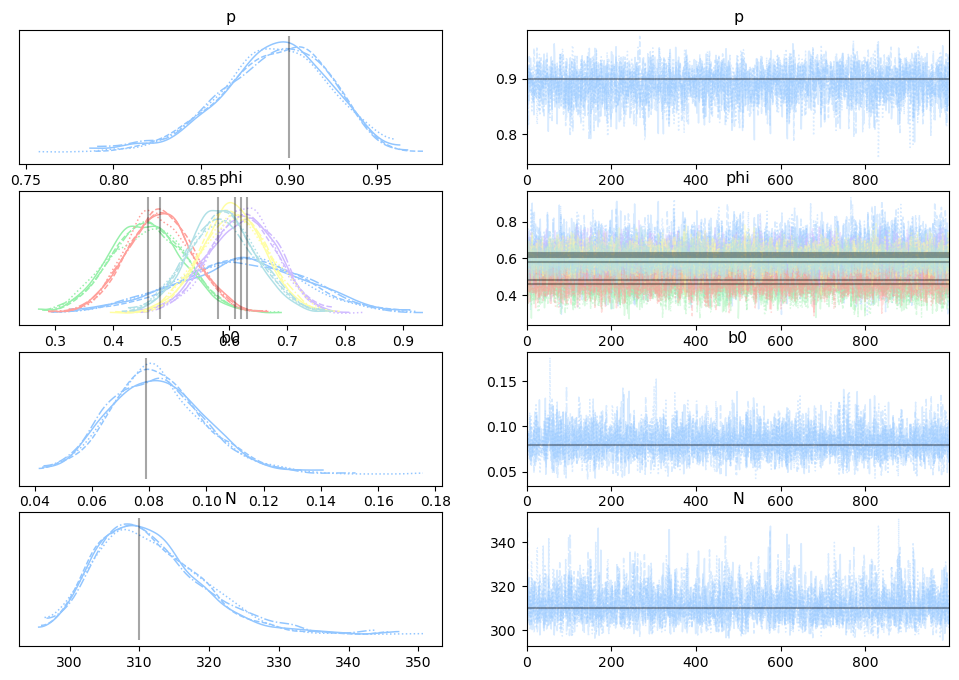

In [17]:
phi_mle = [0.63, 0.46, 0.48, 0.62, 0.61, 0.58]
p_mle = [0.9]
b0_mle = [0.079]
N_mle = [310]

az.plot_trace(
    dat, 
    lines=[("phi", {}, phi_mle), ("p", {}, [p_mle]), ("N", {}, [N_mle]), ("b0", {}, [b0_mle])] 
);

The traceplots include the maximum likelihood estimates from the model, which I estimated usingthe openCR package in R. Again, there is high level of agreement between the two methods. I plot the survival estimates over time, and the posterior draws of $N$, $p$, and $b$.

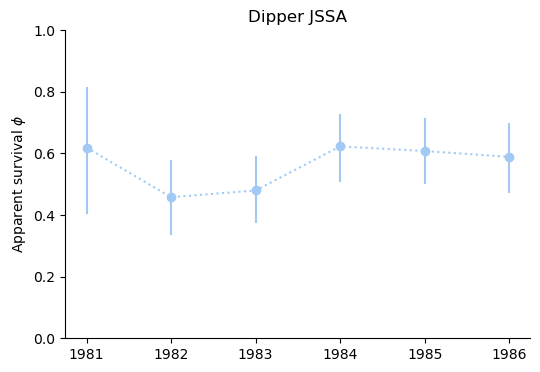

In [18]:
idx = [i for i in az.summary(dat).index if i.startswith('phi')]
sum = az.summary(dat).loc[idx]

phi_mean = sum.iloc[:,0]
phi_low = sum.iloc[:,2]
phi_high = sum.iloc[:,3]

t = np.arange(1981, 1987)

fig, ax = plt.subplots(figsize=(6,4))

ax.scatter(t, phi_mean, label='Estimate', color=col)
ax.plot(t, phi_mean, linestyle='dotted', c=col)
ax.plot([t, t], [phi_low, phi_high], color=col, label='94% Interval')

ax.set_ylabel(r'Apparent survival $\phi$', rotation=90)

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylim((0, 1))

ax.set_title(r'Dipper JSSA')

plt.show()

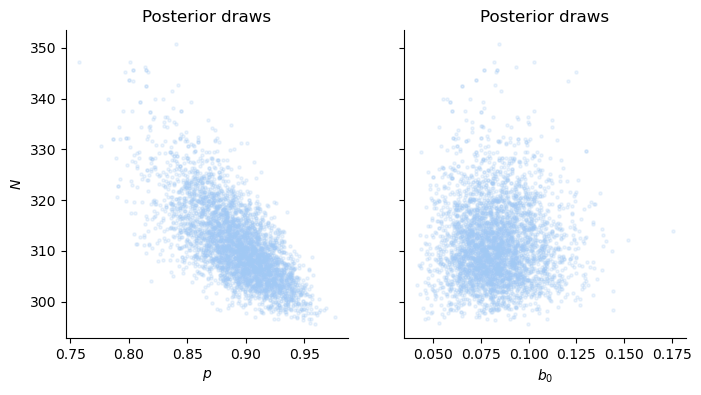

In [19]:
#| fig-cap: Posterior draws of $N,$ $b_0,$ and $p$ for dipper data.
#| fig-lab: post

post = dat.posterior

# stack the draws for each chain, creating a (n_draws, n_species) array 
p_samps = post.p.to_numpy().flatten()
N_samps = post.N.to_numpy().flatten()
b_samps = post.b0.to_numpy().flatten()

# create the plot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

# add the scatter for each species
alph = 0.2
ax0.scatter(p_samps, N_samps, s=5, alpha=alph, color=col)

# update aesthetics 
ax0.spines.right.set_visible(False)
ax0.spines.top.set_visible(False)

ax0.set_ylabel(r'$N$')
ax0.set_xlabel(r'$p$')
ax0.set_title('Posterior draws')

ax1.scatter(b_samps, N_samps, s=5, alpha=alph, color=col)

# update aesthetics 
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)

ax1.set_xlabel(r'$b_0$')
ax1.set_title('Posterior draws')

plt.show()